# JSTNN
## ~~Just Stupid Trivial Neural Network~~
## Joint Structure Thermalized Neural Network

Import necessary packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Data

Define core features of the dataset

In [2]:
dim = 2
numpart = 25
box_size = 10
latent_dim = 5

Import and reshape data

In [3]:
fname = r'\\wsl$\Ubuntu\home\alepitte\ale\uni\variational-autoencoders\mc-sampling\dump\test_25_10_1_0.75_0.2_100000_2500_5_x.txt'
#fname="mc-sampling/good-runs/nonpolimero_x.txt"

with open(fname) as f:
    data = [
        [float(i.strip()) for i in s.split(" ") if i != ""]
        for s in f.read().split("\n")
        if s != ""]

In [4]:
print(data[1])

[3.180787, 2.412516, 7.633109, 2.648419, 5.968157, 1.106966, 4.167049, 1.930876, 9.776027, 2.229036, 2.525097, 0.094556, 2.619431, 1.45399, 4.060368, 3.123917, 0.286433, 0.142511, 4.292573, 0.298462, 9.243757, 0.125158, 9.679416, 0.994678, 6.523954, 0.105735, 4.935052, 1.087431, 5.370665, 0.113932, 5.110775, 2.960006, 3.615703, 4.070283, 0.454368, 1.361296, 8.560841, 1.231844, 9.016901, 2.978163, 1.525243, 0.005543, 3.407643, 0.724244, 8.038712, 0.154833, 1.603654, 1.06262, 1.846255, 2.291894]


In [5]:
vcs = np.array(data).reshape((-1,numpart,dim))/box_size
print(vcs.shape)

(100000, 25, 2)


In [6]:
sortmode = 2

In [7]:
if sortmode == 1 :
    idx = np.lexsort((vcs[:,:,0], vcs[:,:,1]))
    
    # Use the indices to sort each step while maintaining the rows intact
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]
            
    print(sorted_vcs.shape,"\n",sorted_vcs[1])

In [8]:
if sortmode==2:

    # Calculate distances from (0, 0)
    distances = np.sqrt(vcs[:,:,0]**2 + vcs[:,:,1]**2)
    idx = np.argsort(distances, axis=1)
    sorted_vcs = np.empty_like(vcs)
    for i in range(len(vcs)):
        sorted_vcs[i] = vcs[i][idx[i]]

    print(sorted_vcs.shape,"\n",sorted_vcs[1])

(100000, 25, 2) 
 [[2.864330e-02 1.425110e-02]
 [4.543680e-02 1.361296e-01]
 [1.525243e-01 5.543000e-04]
 [1.603654e-01 1.062620e-01]
 [2.525097e-01 9.455600e-03]
 [1.846255e-01 2.291894e-01]
 [2.619431e-01 1.453990e-01]
 [3.407643e-01 7.242440e-02]
 [3.180787e-01 2.412516e-01]
 [4.292573e-01 2.984620e-02]
 [4.167049e-01 1.930876e-01]
 [4.935052e-01 1.087431e-01]
 [4.060368e-01 3.123917e-01]
 [5.370665e-01 1.139320e-02]
 [3.615703e-01 4.070283e-01]
 [5.110775e-01 2.960006e-01]
 [5.968157e-01 1.106966e-01]
 [6.523954e-01 1.057350e-02]
 [8.038712e-01 1.548330e-02]
 [7.633109e-01 2.648419e-01]
 [8.560841e-01 1.231844e-01]
 [9.243757e-01 1.251580e-02]
 [9.016901e-01 2.978163e-01]
 [9.679416e-01 9.946780e-02]
 [9.776027e-01 2.229036e-01]]


In [9]:
train_perc=0.8
trainset = vcs[:int(train_perc*len(data))]
print(trainset.shape)
test_perc=0.25*train_perc
testset = vcs[int(train_perc*len(data)):int((test_perc+train_perc)*len(data))]
print(testset.shape)

(80000, 25, 2)
(20000, 25, 2)


In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
#encoder
input_shape = (numpart,dim)
inputs = layers.Input(shape=input_shape)
x = layers.Flatten()(inputs)
x = layers.Dense(int(numpart*dim*3), activation='relu')(x)#activity_regularizer=regularizers.l1(10e-2))(x)
x = layers.Dense(int(numpart*dim*2), activation='relu')(x)#,activity_regularizer=regularizers.l1(10e-2))(x)
x = layers.Dense(int(numpart*dim*1), activation='relu')(x)#,activity_regularizer=regularizers.l1(10e-2))(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(int(numpart*dim*1), activation="relu")(latent_inputs)
x = layers.Dense(int(numpart*dim*2), activation="relu")(x)
x = layers.Dense(int(numpart*dim*3), activation="relu")(x)
x = layers.Dense(numpart*dim, activation="relu")(x)
decoder_outputs = layers.Reshape((numpart, dim))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 2)]      0           []                               
                                                                                                  
 flatten (Flatten)              (None, 50)           0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 150)          7650        ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          15100       ['dense[0][0]']                  
                                                                                            

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [13]:
#training
reg_lambda=0.0001
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
fit=vae.fit(trainset, epochs=300, batch_size=128, verbose=2)

Epoch 1/300
625/625 - 4s - loss: 0.0568 - reconstruction_loss: 0.0564 - kl_loss: 3.5191 - 4s/epoch - 7ms/step
Epoch 2/300
625/625 - 2s - loss: 0.0519 - reconstruction_loss: 0.0516 - kl_loss: 3.4786 - 2s/epoch - 3ms/step
Epoch 3/300
625/625 - 2s - loss: 0.0515 - reconstruction_loss: 0.0512 - kl_loss: 3.3061 - 2s/epoch - 3ms/step
Epoch 4/300
625/625 - 2s - loss: 0.0444 - reconstruction_loss: 0.0441 - kl_loss: 3.2139 - 2s/epoch - 3ms/step
Epoch 5/300
625/625 - 2s - loss: 0.0394 - reconstruction_loss: 0.0391 - kl_loss: 3.2582 - 2s/epoch - 3ms/step
Epoch 6/300
625/625 - 2s - loss: 0.0389 - reconstruction_loss: 0.0386 - kl_loss: 3.3324 - 2s/epoch - 3ms/step
Epoch 7/300
625/625 - 2s - loss: 0.0384 - reconstruction_loss: 0.0381 - kl_loss: 3.4430 - 2s/epoch - 3ms/step
Epoch 8/300
625/625 - 2s - loss: 0.0380 - reconstruction_loss: 0.0377 - kl_loss: 3.5410 - 2s/epoch - 3ms/step
Epoch 9/300
625/625 - 2s - loss: 0.0377 - reconstruction_loss: 0.0373 - kl_loss: 3.6186 - 2s/epoch - 3ms/step
Epoch 10/3

Epoch 75/300
625/625 - 2s - loss: 0.0306 - reconstruction_loss: 0.0301 - kl_loss: 5.1053 - 2s/epoch - 3ms/step
Epoch 76/300
625/625 - 2s - loss: 0.0300 - reconstruction_loss: 0.0295 - kl_loss: 5.1453 - 2s/epoch - 3ms/step
Epoch 77/300
625/625 - 2s - loss: 0.0304 - reconstruction_loss: 0.0299 - kl_loss: 5.1145 - 2s/epoch - 3ms/step
Epoch 78/300
625/625 - 2s - loss: 0.0299 - reconstruction_loss: 0.0294 - kl_loss: 5.1405 - 2s/epoch - 3ms/step
Epoch 79/300
625/625 - 2s - loss: 0.0301 - reconstruction_loss: 0.0296 - kl_loss: 5.1710 - 2s/epoch - 3ms/step
Epoch 80/300
625/625 - 2s - loss: 0.0297 - reconstruction_loss: 0.0291 - kl_loss: 5.1581 - 2s/epoch - 3ms/step
Epoch 81/300
625/625 - 2s - loss: 0.0298 - reconstruction_loss: 0.0293 - kl_loss: 5.1655 - 2s/epoch - 3ms/step
Epoch 82/300
625/625 - 2s - loss: 0.0298 - reconstruction_loss: 0.0293 - kl_loss: 5.1691 - 2s/epoch - 3ms/step
Epoch 83/300
625/625 - 2s - loss: 0.0299 - reconstruction_loss: 0.0294 - kl_loss: 5.1693 - 2s/epoch - 3ms/step
E

Epoch 149/300
625/625 - 2s - loss: 0.0278 - reconstruction_loss: 0.0273 - kl_loss: 5.3357 - 2s/epoch - 3ms/step
Epoch 150/300
625/625 - 2s - loss: 0.0283 - reconstruction_loss: 0.0278 - kl_loss: 5.3871 - 2s/epoch - 3ms/step
Epoch 151/300
625/625 - 2s - loss: 0.0282 - reconstruction_loss: 0.0276 - kl_loss: 5.4208 - 2s/epoch - 3ms/step
Epoch 152/300
625/625 - 2s - loss: 0.0288 - reconstruction_loss: 0.0283 - kl_loss: 5.4699 - 2s/epoch - 3ms/step
Epoch 153/300
625/625 - 2s - loss: 0.0291 - reconstruction_loss: 0.0285 - kl_loss: 5.4206 - 2s/epoch - 3ms/step
Epoch 154/300
625/625 - 2s - loss: 0.0295 - reconstruction_loss: 0.0289 - kl_loss: 5.4021 - 2s/epoch - 3ms/step
Epoch 155/300
625/625 - 2s - loss: 0.0285 - reconstruction_loss: 0.0279 - kl_loss: 5.3771 - 2s/epoch - 3ms/step
Epoch 156/300
625/625 - 2s - loss: 0.0283 - reconstruction_loss: 0.0278 - kl_loss: 5.3820 - 2s/epoch - 3ms/step
Epoch 157/300
625/625 - 2s - loss: 0.0289 - reconstruction_loss: 0.0283 - kl_loss: 5.4480 - 2s/epoch - 3

Epoch 223/300
625/625 - 2s - loss: 0.0276 - reconstruction_loss: 0.0271 - kl_loss: 5.2219 - 2s/epoch - 3ms/step
Epoch 224/300
625/625 - 2s - loss: 0.0276 - reconstruction_loss: 0.0270 - kl_loss: 5.2184 - 2s/epoch - 3ms/step
Epoch 225/300
625/625 - 2s - loss: 0.0273 - reconstruction_loss: 0.0267 - kl_loss: 5.2958 - 2s/epoch - 3ms/step
Epoch 226/300
625/625 - 2s - loss: 0.0270 - reconstruction_loss: 0.0265 - kl_loss: 5.3876 - 2s/epoch - 4ms/step
Epoch 227/300
625/625 - 2s - loss: 0.0274 - reconstruction_loss: 0.0268 - kl_loss: 5.3546 - 2s/epoch - 4ms/step
Epoch 228/300
625/625 - 2s - loss: 0.0272 - reconstruction_loss: 0.0267 - kl_loss: 5.3962 - 2s/epoch - 3ms/step
Epoch 229/300
625/625 - 2s - loss: 0.0279 - reconstruction_loss: 0.0274 - kl_loss: 5.3573 - 2s/epoch - 4ms/step
Epoch 230/300
625/625 - 2s - loss: 0.0282 - reconstruction_loss: 0.0276 - kl_loss: 5.3694 - 2s/epoch - 4ms/step
Epoch 231/300
625/625 - 3s - loss: 0.0276 - reconstruction_loss: 0.0271 - kl_loss: 5.4872 - 3s/epoch - 4

Epoch 297/300
625/625 - 2s - loss: 0.0274 - reconstruction_loss: 0.0269 - kl_loss: 5.4607 - 2s/epoch - 3ms/step
Epoch 298/300
625/625 - 2s - loss: 0.0276 - reconstruction_loss: 0.0270 - kl_loss: 5.5848 - 2s/epoch - 4ms/step
Epoch 299/300
625/625 - 2s - loss: 0.0276 - reconstruction_loss: 0.0271 - kl_loss: 5.4841 - 2s/epoch - 4ms/step
Epoch 300/300
625/625 - 2s - loss: 0.0283 - reconstruction_loss: 0.0277 - kl_loss: 5.6037 - 2s/epoch - 3ms/step


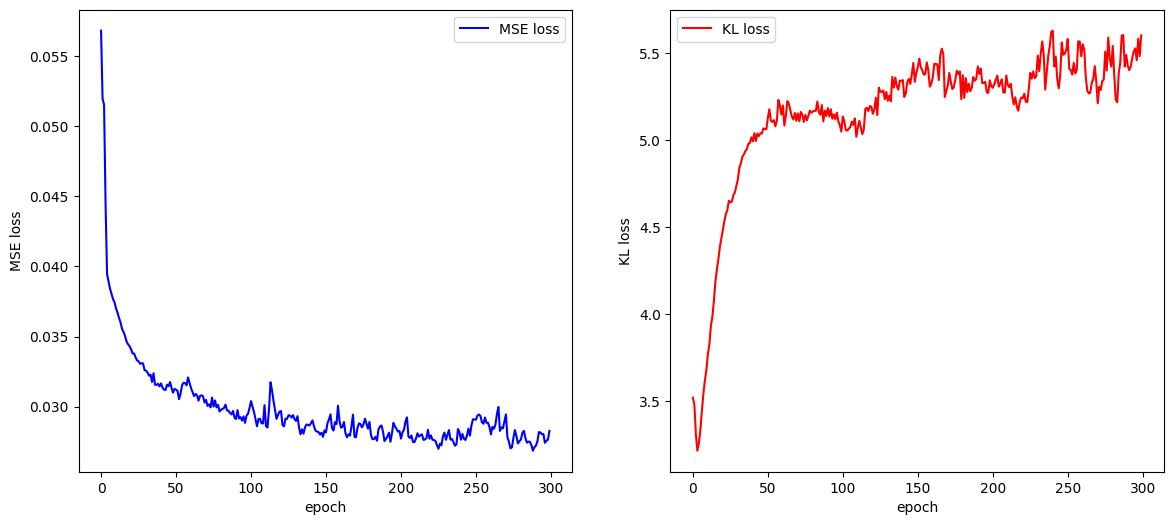

In [14]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['loss'],label="MSE loss",c="b")
ax.set_xlabel('epoch')
ax.set_ylabel("MSE loss")
ax.legend()
ax=AX[1]
ax.plot(fit.history['kl_loss'],label="KL loss",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("KL loss")
ax.legend()

## Evaluate performance
We'll now use the test set to explore the latent space distribution of data and the reconstruction accuracy

In [15]:
encoded_test = np.array(vae.encoder.predict(testset))

625/625 [==============================] - 1s 1ms/step


In [16]:
print(encoded_test.shape)

(3, 20000, 5)


z_mean are the first dimension, z_log_var the second (used in training), we're interested in the third dimension, which are the sampled z

In [17]:
dim1 = encoded_test[2,:,:]
print(dim1.shape)

(20000, 5)


Sampling in the latent space is reasonably gaussian as expected

In [18]:
#df = pd.DataFrame(dim1, columns=["x", "y"])
#sns.jointplot(x="x", y="y", data=df);

We can now use the data to decode

In [19]:
decoded_test = np.array(decoder.predict(encoded_test[2,:,:])).reshape(-1,numpart,dim)
print(decoded_test.shape)

625/625 [==============================] - 1s 1ms/step
(20000, 25, 2)


#### Check reconstruction

In [20]:
decoded_test[2]

array([[0.67650276, 0.13860153],
       [0.64028215, 0.13918926],
       [0.01230216, 0.15070215],
       [0.71175456, 0.14432615],
       [0.73065525, 0.14199169],
       [0.21327055, 0.13986684],
       [0.8234536 , 0.1453484 ],
       [0.17561516, 0.1360021 ],
       [0.5938773 , 0.13739996],
       [0.19842826, 0.14706238],
       [0.24771565, 0.15026239],
       [0.8112823 , 0.16209495],
       [0.64466906, 0.13610151],
       [0.60257095, 0.148016  ],
       [0.55391395, 0.14653762],
       [0.57619166, 0.15297961],
       [0.5221346 , 0.14983603],
       [0.21217021, 0.15116662],
       [0.5766885 , 0.15131709],
       [0.4150125 , 0.13766547],
       [0.4041223 , 0.14035462],
       [0.50023896, 0.1708591 ],
       [0.32799476, 0.13955511],
       [0.94596803, 0.15731134],
       [0.41346216, 0.13653347]], dtype=float32)

In [21]:
ts = testset.reshape(-1,numpart,dim)
print(ts[2,:,:])

[[0.7357396 0.0551421]
 [0.5976948 0.0157178]
 [0.0055137 0.2758676]
 [0.98007   0.2209758]
 [0.9461167 0.0082251]
 [0.128084  0.0174725]
 [0.8863216 0.1144696]
 [0.0517938 0.1546137]
 [0.63611   0.1121959]
 [0.1256817 0.2414754]
 [0.0260303 0.0547474]
 [0.77417   0.1767987]
 [0.2551465 0.0290568]
 [0.8193441 0.0044778]
 [0.4192217 0.1262172]
 [0.4999296 0.0587548]
 [0.5977047 0.2993228]
 [0.3657233 0.0310318]
 [0.5004398 0.1824724]
 [0.8321848 0.4347155]
 [0.710374  0.2999053]
 [0.3081798 0.115296 ]
 [0.1989948 0.114941 ]
 [0.9915429 0.1123716]
 [0.4722454 0.2955366]]


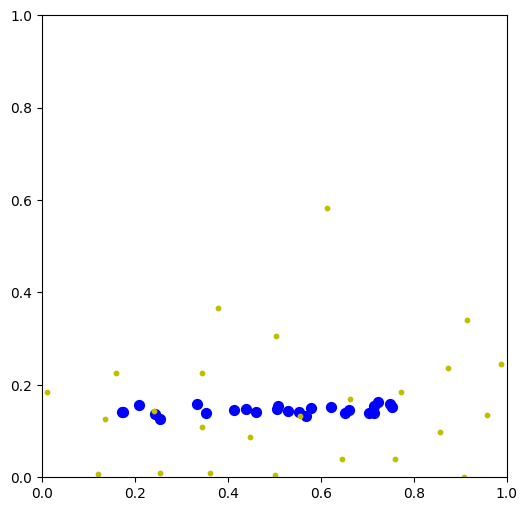

In [22]:
if dim == 2:
    ind = 1
    plt.figure(figsize=(6, 6))
    plt.scatter(decoded_test[ind,:,0], decoded_test[ind,:,1], s=50, c="b")
    plt.scatter(ts[ind,:,0], ts[ind,:,1], s=10, c="y")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

MovieWriter imagemagick unavailable; using Pillow instead.


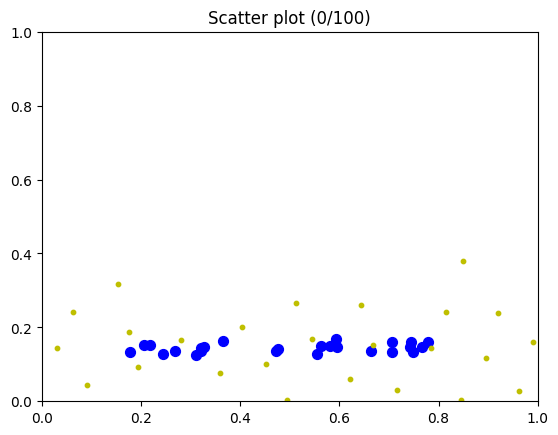

In [23]:
from matplotlib.animation import FuncAnimation

# Create the figure and axis objects
fig, ax = plt.subplots()

nframes = 100

# Define the animation function
def update(ind):
    ax.clear()
    plt.scatter(decoded_test[ind,:,0], decoded_test[ind,:,1], s=50, c="b")
    plt.scatter(ts[ind,:,0], ts[ind,:,1], s=10, c="y")
    ax.set_title(f"Scatter plot ({ind}/{nframes})")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

# Create the animation
animation = FuncAnimation(fig, update, frames=nframes, interval=200)

# Save the animation as a GIF
animation.save("prediction.gif", writer="imagemagick")


In [24]:
if dim ==3:
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(decoded_test[1,:,0], decoded_test[1,:,1],decoded_test[1,:,2], s=30, c="b", depthshade=True)
    ax.scatter(ts[1,:,0], ts[1,:,1],ts[1,:,2], s=30, c="y", depthshade=True)
    ax.view_init(45,45)

3125/3125 [==============================] - 5s 2ms/step
0.44579112077406297 0.28399901593194976 0.7297901367060127


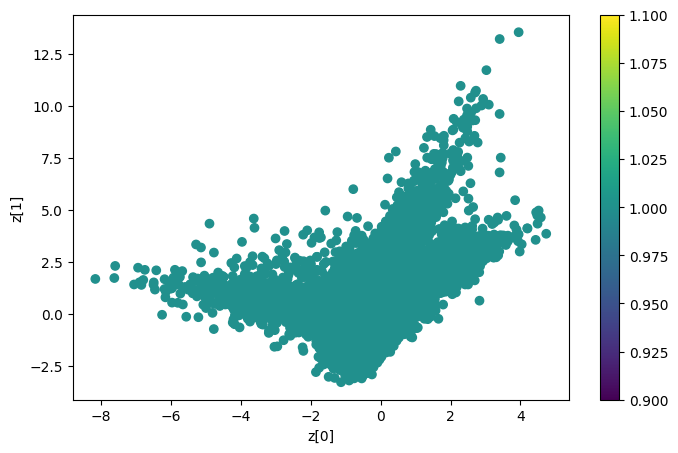

In [25]:
from scipy import linalg as la

labels = [1]*len(data)
def label_vis(vae, data, labels):
    
    #prediction
    z_mean, _, _ = vae.encoder.predict(data)
    
    #PCA on z_mean
    A = pd.DataFrame(z_mean)
    l, V = la.eig(np.cov(A.T))
    lr = np.copy(l.real)
    n1 = np.argmax(l)
    l[n1] = 0
    n2 = np.argmax(l)
    print(lr[n1]/sum(lr), lr[n2]/sum(lr), (lr[n1]+lr[n2])/sum(lr) )

    #plot
    plt.figure(figsize=(8, 5))
    plt.scatter(z_mean[:, n1], z_mean[:, n2], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

label_vis(vae, vcs, labels)